In [2]:
### This trial notebook works to predict the ternary diagram for R32/R125/bmimAc at 0.2 MPa, 298 K

In [3]:

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [6]:
# import ternary params 
from HFCS_bmimAc_PR import configuration

## Create Model

In [7]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-04-25 22:37:52 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [8]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [9]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [11]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimAc"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [21]:
IL_z = [0.01,0.4,0.72,0.91,0.99] # changed 0.001 to 0.01 bc infeasible
IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

for j in range(len(IL_z)):

    fract = 1 - IL_z[j] #Think about this
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*IL_z[j])
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "bmimAc"].fix(0.15)   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              
    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimAc"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimAc"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        #Change this to feasible
        print(value(m.fs.F101.liq_outlet.flow_mol[0]))
        print(value(m.fs.F101.vap_outlet.flow_mol[0]))
    else:
        print('Infeasible.')

0.1981487013640915
0.8018512986359084
0.18868496183887762
0.8113150381611224
0.18130714642873988
0.8186928535712601
0.17707163634127682
0.8229283636587231
0.17531802589116585
0.8246819741088341


In [22]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [0.75700723 0.79497591 0.82732536 0.84711478 0.855588  ]
IL_y = [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
R32_x = [0.00142343 0.05702665 0.10290122 0.13030918 0.14189623]
R32_y = [0.01024872 0.40581021 0.72474466 0.91189704 0.99022782]
R125_x = [0.24156934 0.14799744 0.06977342 0.02257604 0.00251576]
R125_y = [0.98975128 0.59418979 0.27525534 0.08810296 0.00977218]


## Store Ternary Data

In [23]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i], R32_x[i], R125_x[i])
    points_x.append(points)
    
print(points_x)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i], R32_y[i], R125_y[i])
    points_y.append(points)
    
print(points_y)

[(0.7570072322816055, 0.0014234305297983329, 0.24156933718859622), (0.79497591402164, 0.05702664922623866, 0.1479974367521215), (0.8273253589535441, 0.10290122107896223, 0.06977341996749374), (0.8471147785120106, 0.13030918318794446, 0.022576038300045037), (0.8555880049268636, 0.14189623481508173, 0.0025157602580547648)]
[(1e-08, 0.01024871956094834, 0.9897512804390517), (1e-08, 0.40581021351851615, 0.5941897864814839), (1e-08, 0.7247446593113507, 0.27525534068864926), (1e-08, 0.911897040911601, 0.08810295908839905), (1e-08, 0.9902278185639646, 0.009772181436035416)]


## Plot Diagram

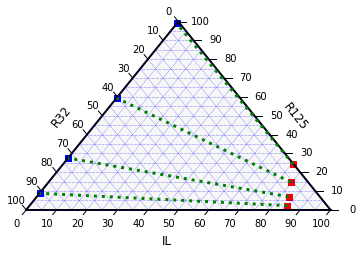

In [24]:
points_x = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_x[i]*100, R125_x[i]*100, R32_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_y[i]*100, R125_y[i]*100, R32_y[i]*100)
    points_y.append(points)

import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
# tax.set_title("Ternary phase diagram 8 bar\n", fontsize=24)
tax.left_axis_label("R32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

#for pressure changing plot would need to draw line between x[0] and x[final] for the indivual pressure
#use tax.line with the tax.scatter below
for i in range(4):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")

# make this tax.line
tax.scatter(points_x, marker='s', color='red', label="liquid")
#Comment out for pressure changing plot
tax.scatter(points_y, marker='s', color='blue', label="vapor")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()